# Scopone Scientifico parallel enviroment
### Alessandro Castoldi
The aim of this notebook is to investigate how the transition function works and whether it is functioning correctely in a *DISCRETE* space! The framework decentralized partially observable Markov decision processe (DEC-POMDP) [Oliehoek, F. A., & Amato, C. (2016). A concise introduction to decentralized POMDPs (Vol. 1). Cham, Switzerland: Springer International Publishing.]

DEC-POMDP is formally defined by the 7th-tuple:$$\langle \mathcal{S}, \mathcal{A}, \mathcal{O}, R, P, n, \gamma \rangle$$


Given the multi agent nature of the project we define a `Local State` which only contains information from the perspective of a single agent with $a_i
\in\mathcal{A}$ and `State` $\mathcal{S}$ as the sum of all states given for all agents $\mathcal{A}$. 

The scope of this notebook is to study the transition from $s$ to $s'$ and the shared reward function $R(S,A) = \sum_{i=0}^{n} R(s_i,a_i)$ to further investigate probability $P(s'|s,A)$.

The game of Scopone Scientifico can be seen as a *Markov Decision Process* but as such every "step" for each action $a_i\in\mathcal{A_j}$ where $\mathcal{A_j}$ represents the action space for agent $j$ an action that corresponds to a trainsition has to be chosen. The action set of for a given player always has size 40 which is a one-hot encoded vector represeting the deck used by the game. Not all actions can be taken in a state and thus the need for an action-masking function arises. [dearXiv:2006.14171v3 [cs.LG] 31 May 2022] proposes to use the big $M$ with $M=-10^8$ technique from LP and mask the logits with invalid position before the last softmax operation in the neural network. This way the final output of the network will adapt to the missing actions and adjust the probabilities.

The example provided by Huang and Ontanon:
Consider the single-agent/single-network MDP with action set $\mathcal{A} = \{a_0,a_1,a_2,a_3\}$ and states $\mathcal{S} = \{s_0,s_1\}$ where $s_1$ is a terminal state. Given policy $\pi_0$ parametrised for $\theta = [l_0,l_1,l_2,l_3] = [1.0,1.0,1.0,1.0]$ that, for the sake of this example, directly produces as the output logits.

$$\pi_\theta(\cdot|s_0) = [\pi_\theta(a_0|s_0),\pi_\theta(a_1|s_0),\pi_\theta(a_2|s_0),\pi_\theta(a_3|s_0)] = $$
$$ = \text{softmax}([l_0,l_1,l_2,l_3])=\bigg[\frac{1}{4},\frac{1}{4},\frac{1}{4},\frac{1}{4}\bigg] \text{ where } \pi_\theta(a_i|s_0) = \frac{\exp(l_i)}{\sum_j \exp(l_j)}$$

with the masked process then this becomes:
$$\pi'_\theta(\cdot|s_0) = \text{softmax}(mask[l_0,l_1,l_2,l_3])=\text{softmax}(mask[l_0,l_1,M,l_3]) = $$ 
$$ = [\pi'_\theta(a_0|s_0),\pi'_\theta(a_1|s_0),\epsilon,\pi'_\theta(a_3|s_0)] = \bigg[\frac{1}{3},\frac{1}{3},0,\frac{1}{3}\bigg]$$
where $\epsilon$ is the resulting probability of the invalid actions with a small value close to zero.




NOTE TO SELF: Unlike off-policy methods, PPO
does not utilize a replay buffer to train on samples collected throughout training. MAPPO (arXiv:2103.01955v4 [cs.LG] 4 Nov 2022) uses centralised training which would not work in a mixed enviroment such as the one of the game Scopone.

In [28]:
from gymnasium import spaces

observation_space = spaces.MultiBinary((3,40))

action_space = spaces.Box(0, 1, shape=(1,40))

In [29]:
obs = observation_space.sample()
act = action_space.sample()

mask = obs[0]

print('observation:', obs)
print('action:', act[0])
print('action-masked:', (act*mask)[0])


observation: [[1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0
  0 1 1 0]
 [0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1
  1 1 1 1]
 [0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0
  1 1 0 1]]
action: [0.80826277 0.8693319  0.8528898  0.55528885 0.29486966 0.6107372
 0.77806306 0.02415431 0.17515187 0.45400494 0.4815036  0.25615475
 0.554931   0.20082004 0.44388604 0.79947764 0.79997957 0.48326507
 0.7251019  0.99893373 0.09232935 0.942758   0.9721687  0.03660893
 0.23022518 0.62362236 0.19774663 0.4212405  0.7824792  0.28424153
 0.22848256 0.7466359  0.61334616 0.97763157 0.7795223  0.8585584
 0.9598772  0.86331904 0.51146984 0.5519948 ]
action-masked: [0.80826277 0.8693319  0.8528898  0.         0.         0.6107372
 0.77806306 0.02415431 0.17515187 0.45400494 0.4815036  0.
 0.554931   0.20082004 0.44388604 0.         0.         0.
 0.7251019  0.         0.         0.         0.         0.03660893
 0.23022518

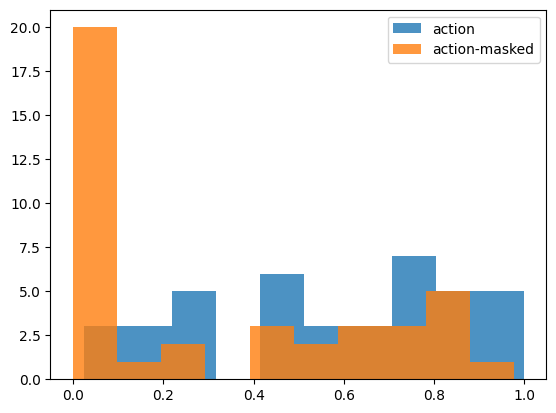

In [39]:
import matplotlib.pyplot as plt

plt.hist(act[0], bins=10, alpha=0.8)
plt.hist((act*mask)[0], bins=10, alpha=0.8)
plt.legend(['action', 'action-masked'])
plt.show()

In [3]:
from ptzoo.maenv.ma_scopa_env import MaScopaEnv
from tqdm import tqdm
import numpy as np


env = MaScopaEnv()
env.reset()

for agent in tqdm(env.agent_iter()):


    print('agent:', agent)
    print('selected:', env.agent_selection)

    obs, rew, t,tt, info = env.last(observe=True)

    if t or tt:
        break

    print('obs:', obs)
    print('rew:', rew)
    print('t:', t)
    print('tt:', tt)
    print('info:', info)


    actionspace = env.action_space(agent).sample() * info['action_mask']
    
    print('avaliable:', sum(info['action_mask']))

    act = np.argmax(actionspace)

    if sum(info['action_mask']) == 0: act = None

    print('act:', act)

    env.step(act)
    


40it [00:00, 1941.00it/s]

agent: player_2
selected: player_2
obs: [[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
rew: 0
t: False
tt: False
info: {'action_mask': array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1])}
avaliable: 10
act: 25
agent: player_3
selected: player_3
obs: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 

In [26]:
print(env.agent_selection)
print(env.last())
print(env.__str__())

player_1
(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 1.]]), 0, True, False, {'action_mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})
scopa_v0


In [5]:
print(env.rewards)

{'player_2': 0, 'player_3': 0, 'player_0': 0, 'player_1': 0}


100%|██████████| 100000/100000 [02:21<00:00, 706.64it/s]


(array([43559., 12358., 44083.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

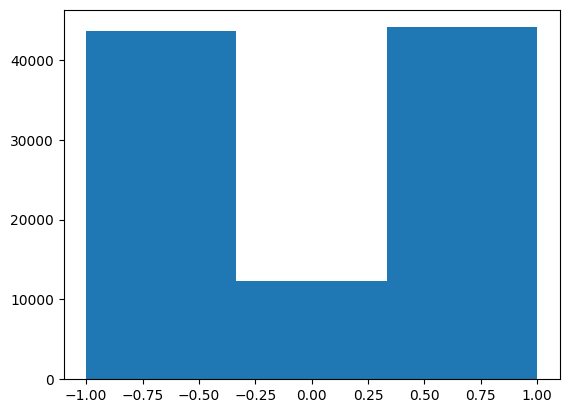

In [3]:
from ptzoo.maenv.ma_scopa_env import MaScopaEnv
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

scores = []

for n in tqdm(range(100000)):
    env = MaScopaEnv()
    env.reset()

    for agent in env.agent_iter():

        obs, rew, t,tt, info = env.last(observe=True)

        if t or tt:
            break


        actionspace = env.action_space(agent).sample() * info['action_mask']
        
        act = np.argmax(actionspace)

        env.step(act)
    scores.append(env.rewards['player_0'])

plt.hist(scores, bins=3)